# Segmentez les comportements des clients - Nettoyage

In [1]:
#%%script echo skipping
#from google.colab import drive
#drive.mount('/content/drive')

# SOMMAIRE
* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [CARACTERISTIQUES](#CARACTERISTIQUES)
* [CREATIONS DE VARIABLES](#CREATIONS-DE-VARIABLES)
* [NETTOYAGE](#NETTOYAGE)
* [SAUVEGARDE](#SAUVEGARDE)

# PREPARATION

## Import des librairies

In [2]:
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import pandas as pd
import seaborn as sns
import joblib
from datetime import timedelta
import numpy as np


## Paramétrage du notebook

In [3]:
from matplotlib import font_manager

font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Comic Sans'
plt.rcParams['font.sans-serif'] = 'Franklin Gothic Book'

In [4]:
sns.set(rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

#mplt.font_manager._rebuild()
#mplt.font_manager.findfont('Franklin Gothic Book',rebuild_if_missing=True)


pd.set_option('display.min_rows', 15)

## Declaration des fonctions

In [5]:
def profil(df):
    """
    Fonction qui retourne le profil des données d'un dataframe (moyenne, ecart type, min, max, valeurs manquantes, valeurs uniques)

    Parameters
    ----------
    df : DataFrame
        un DataFrame de données

    Returns
    -------
    result : DataFrame
        un DataFrame de profil, contenant un résumé statistique des données
    """
    
    dfValeursManquantes=pd.concat([df.isnull().sum(),100*df.isnull().sum()/len(df)],axis=1,keys=["missing_values","%_missing_values"])
    #dfValeursUniques=pd.concat([df.nunique(),100*(df.nunique()/len(df))],axis=1,keys=["unique_values","%_unique_values"])
    dfTypes=pd.DataFrame({'type':df.dtypes})
    result=df.describe(include='all',datetime_is_numeric=True).T
    result=result.merge(dfTypes,left_index=True,right_index=True)
    result=result.merge(dfValeursManquantes,left_index=True,right_index=True)
    #result=result.merge(dfValeursUniques,left_index=True,right_index=True)
    return result

def summarizeFrequenciesDf(df,threshold):
    """
    Fonction mode qui agrege les variables qui sont sous un seuil 'threshold'(pour les très gros dataframe qui ont du mal à plotter)

    Parameters
    ----------
    df : DataFrame
        un DataFrame de données
    threshold: Int
        seuil au dessous duquel le comptage des observations sont agrégées dans la catégorie 'autres'

    Returns
    -------
    result : DataFrame
        un DataFrame contenant le comptage des observations au dessus du seuil et tout le reste dans la catégorie 'Autres'
    """

    dfFrequencies=df.value_counts()
    dfNormalizedFrequencies=df.value_counts(normalize=True) # frequence normalisée des valeurs de chaque variable
    mask = dfNormalizedFrequencies>threshold # masque sur les fréquences > seuil
    dfTail= dfFrequencies.loc[~mask].sum()
    dfFrequencies=dfFrequencies.loc[mask] # filtre sur les fréquences < seuil
    dfFrequencies['Autres']=dfTail # ajout des fréquences > seuil agregées dans la categorie 'Autre'
    return pd.DataFrame(dfFrequencies)

def plotCategoricalDistributions(plt,df,nrows,ncols,subfigwidth,subfigheight):
    """
    Fonction affiche les distributions des variables categorielles d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    nrows: Int
        nombre de lignes des sous-figures
    ncols: Int
        nombre de colonnes des sous-figures
    subfigwidth: Int
        largeur des sous-figures
    subfigheight: Int
        hauteur des sous-figures

    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage

    """
    dfCategorical=df.select_dtypes(include=['object','string', 'category'])
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(subfigwidth,subfigheight))

    # Titre
    fig.suptitle("Distribution Variables Categorielles", fontsize=20)
    fig.subplots_adjust(top=1.5)
    
    # axes est un tableau à 2 dimensions: lignes, colonnes
    # pour parcourir les subplot, il faut réduire axes à une dimension avec flatten
    axes=axes.flatten()
    
    # espace vertical entre les rangées de sous graphiques
    plt.tight_layout(pad=4)
    
    i=0
    for x in dfCategorical.columns:
        # passe les labels sur l'axe des x en arriere plan
        axes[i].xaxis.label.set_visible(False)
        
        # On classe dans la categorie "Autres" les variables sous le seuil de 0,5% de frequence d'observation,
        dfCurrent=summarizeFrequenciesDf(dfCategorical[x],0.005)
    
        axes[i].bar(dfCurrent[x].index,dfCurrent[x],color='#ee6352')
        axes[i].tick_params(axis='x', rotation=-90)
        axes[i].set_title(x,color='#3fa7d6')
    
        i=i+1
    plt.show()
        
def plotQuantitativeDistributions(plt,df,nrows,ncols,subfigwidth,subfigheight):
    """
    Fonction affiche les distributions des variables quantitatives d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    nrows: Int
        nombre de lignes des sous-figures
    ncols: Int
        nombre de colonnes des sous-figures
    subfigwidth: Int
        largeur des sous-figures
    subfigheight: Int
        hauteur des sous-figures
    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage

    """
    dfQuantitative=df.select_dtypes(exclude=['object','string', 'category'])
    dfQSkew=dfQuantitative.skew(skipna = True).to_frame('SKEW')
    dfQColumnsSorted=dfQSkew.sort_values(by='SKEW',ascending=False).T.columns #tri des colonnes par valeur de skew

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(subfigwidth,subfigheight))
    
    # Titre
    fig.suptitle("Distribution Variables Quantitatives", fontsize=20)
    fig.subplots_adjust(top=1.5)
    
    # axes est un tableau à 2 dimensions: lignes, colonnes
    # pour parcourir les subplot, il faut réduire axes à une dimension avec flatten
    axes=axes.flatten()
    
    # espace vertical entre les rangées de sous graphiques
    plt.tight_layout(pad=4)
    
    dfQuantitative
    i=0
    for x in dfQColumnsSorted:
        #dfCurrent=dfNumerical[x].sample(1000,replace=True).sort_index() #optimisation pour les large datasets
        dfCurrent=dfQuantitative[x].dropna(axis=0)
        # passe les labels sur l'axe des x en arriere plan
        axes[i].xaxis.label.set_visible(False)    
        
        axes[i].hist(dfCurrent,color='#3fa7d6')
        axes[i].tick_params(axis='x', rotation=-90)
        axes[i].set_title(x,color='#ee6352')
    
        i=i+1
    plt.show()

def plotCorrelationHeatmap(plt,df):
    """
    Fonction affiche la heatmap des correlation d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage

    """
    dfCorr=df.corr()
    plt.rcParams["figure.figsize"] = (10,10)
    plt.matshow(dfCorr,cmap='coolwarm',interpolation='nearest')
    plt.xticks(range(len(dfCorr.columns)), dfCorr.columns, size='small',rotation='vertical');
    plt.yticks(range(len(dfCorr.columns)), dfCorr.columns, size='small');
    plt.show()
    
def plotBoxes(plt,df,nrows,ncols):
    """
    Fonction affiche les boites à moustache des variables quantitatives d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    nrows: Int
        nombre de lignes des sous-figures
    ncols: Int
        nombre de colonnes des sous-figures
    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage
    """
    dfQuantitative=df.select_dtypes(exclude=['object','string', 'category'])

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14,20))
    
    # espace vertical entre les rangées de sous graphiques
    plt.tight_layout(pad=3)


    # axes est un tableau à 2 dimensions: lignes, colonnes
    # pour parcourir les subplot, il faut réduire axes à une dimension avec flatten
    axes=axes.flatten()
    
    i=0
    for x in dfQuantitative.columns:
            axes[i].boxplot(dfQuantitative[x].dropna())
            axes[i].set_title(x,color='#3fa7d6')
            i+=1
    plt.show()
            
def maskOutliers(s):
    """
    Fonction qui retourne le mask qui retourne les lignes d'une Serie, correspondant aux outliers

    Parameters
    ----------
    s : pandas Series
        une Serie de valeurs numériques

    Returns
    -------
    mask : Series
        une Serie de booleens correspondant au masque qui retourne les valeurs atypiques/Outliers
    """
    # premier Quantile
    Q1 = s.quantile(0.25)
    # 3e quantile
    Q3 = s.quantile(0.75)
    # Interquantile
    IQR = Q3 - Q1
    
    # les outliers sont toutes les valeurs qui sont inférieures à Q1-1.5*IQR et supérieure à  Q3+1.5*IQR
    mask=(s < (Q1 - 1.5 * IQR)) |(s > (Q3 + 1.5 * IQR))
    return mask

# CHARGEMENT

In [6]:
#df=pd.read_excel("../Dataset/OnlineRetail.xlsx", engine='openpyxl')

In [7]:
#joblib.dump(df,"dfOnlineRetail.jbl.bz2")

In [8]:
#df=joblib.load("drive/MyDrive/Colab Notebooks/Datasets/dfOnlineRetail.jbl.bz2")
df=joblib.load("dfOnlineRetail.jbl.bz2")

# CARACTERISTIQUES

## Profil

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [10]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
529674,580744,22100,SKULLS SQUARE TISSUE BOX,108,2011-12-06 09:31:00,0.39,13694.0,United Kingdom
315724,564734,22384,LUNCH BAG PINK POLKADOT,4,2011-08-28 13:32:00,1.65,12484.0,Spain
377250,569545,21579,LOLITA DESIGN COTTON TOTE BAG,1,2011-10-04 16:37:00,4.96,NaN,United Kingdom
338369,566539,23390,DOLLY GIRL MINI BACKPACK,2,2011-09-13 11:34:00,4.15,17228.0,United Kingdom
282606,561651,23199,JUMBO BAG APPLES,1,2011-07-28 15:36:00,4.13,NaN,United Kingdom


In [11]:
dfProfil=profil(df)
dfProfil

,count,unique,top,freq,mean,min,25%,50%,75%,max,std,type,missing_values,%_missing_values
InvoiceNo,541909.0,25900.0,573585.0,1114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.000000
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.000000
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,1454,0.268311
Quantity,541909.0,NaN,NaN,NaN,9.55225,-80995.0,1.0,3.0,10.0,80995.0,218.081158,int64,0,0.000000
InvoiceDate,541909,NaN,NaN,NaN,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN,datetime64[ns],0,0.000000
UnitPrice,541909.0,NaN,NaN,NaN,4.611114,-11062.06,1.25,2.08,4.13,38970.0,96.759853,float64,0,0.000000
CustomerID,406829.0,NaN,NaN,NaN,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303,float64,135080,24.926694
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.000000


## Doublons

In [12]:
maskDoublons=df.duplicated(keep=False)
df[maskDoublons].sort_values([df.columns[0],df.columns[1]])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
436251,C574095,22326,ROUND SNACK BOXES SET OF4 WOODLAND,-1,2011-11-03 09:54:00,2.95,12674.0,France
440148,C574510,22360,GLASS JAR ENGLISH CONFECTIONERY,-1,2011-11-04 13:25:00,2.95,15110.0,United Kingdom


=> Ces doublons seront à supprimer dans la partie "NETTOYAGE"

## Completude

Les variables StockCode et InvoiceNo contiennent des alphanumériques et des numériques => pour homogeneiser le type nous convertissons la colonne en alphanumérique

In [13]:
# Homogeneiser les types par colonnes
df['StockCode']=df['StockCode'].astype('str')
df['InvoiceNo']=df['InvoiceNo'].astype('str')

In [14]:
# Homogeneiser les code produits et description
maskStockDescription=df[['StockCode','Description']].drop_duplicates().sort_values('StockCode').index

In [15]:
dictStockCodeDescription=dict(zip(df.iloc[maskStockDescription]['StockCode'].tolist(),df.iloc[maskStockDescription]['Description'].tolist()))

In [16]:
keysToDelete=[k for k,v in dictStockCodeDescription.items() if pd.isnull(v)]

In [17]:
for key in keysToDelete:
  del dictStockCodeDescription[key]

In [18]:
# etude des valeurs du couple de variable StockCode, Description
maskDoublonsStockDescription=df.duplicated(['InvoiceNo','Description','InvoiceDate','Quantity','UnitPrice'],keep=False)
df[maskDoublonsStockDescription].sort_values(by=['Description','StockCode'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
160498,550459,72800B,4 PURPLE FLOCK DINNER CANDLES,1,2011-04-18 13:17:00,2.55,18116.0,United Kingdom
160509,550459,72800B,4 PURPLE FLOCK DINNER CANDLES,1,2011-04-18 13:17:00,2.55,18116.0,United Kingdom
483390,577503,72800B,4 PURPLE FLOCK DINNER CANDLES,1,2011-11-20 12:34:00,2.55,18110.0,United Kingdom
483414,577503,72800B,4 PURPLE FLOCK DINNER CANDLES,1,2011-11-20 12:34:00,2.55,18110.0,United Kingdom
460074,575895,23345,DOLLY GIRL BEAKER,1,2011-11-11 14:50:00,1.25,17052.0,United Kingdom
460098,575895,23345,DOLLY GIRL BEAKER,1,2011-11-11 14:50:00,1.25,17052.0,United Kingdom
503147,578921,23345,DOLLY GIRL BEAKER,1,2011-11-27 11:57:00,1.25,13596.0,United Kingdom
...,...,...,...,...,...,...,...,...
144652,548792,84836,ZINC METAL HEART DECORATION,1,2011-04-04 12:42:00,1.25,14711.0,United Kingdom
499528,578678,84836,ZINC METAL HEART DECORATION,1,2011-11-24 19:59:00,1.25,17841.0,United Kingdom


Le code produit peut contenir des minuscules ou des majuscules et sont assimilées à deux code différents => dans la partie nettoyage, nous mettrons tout en majuscule

## Distributions

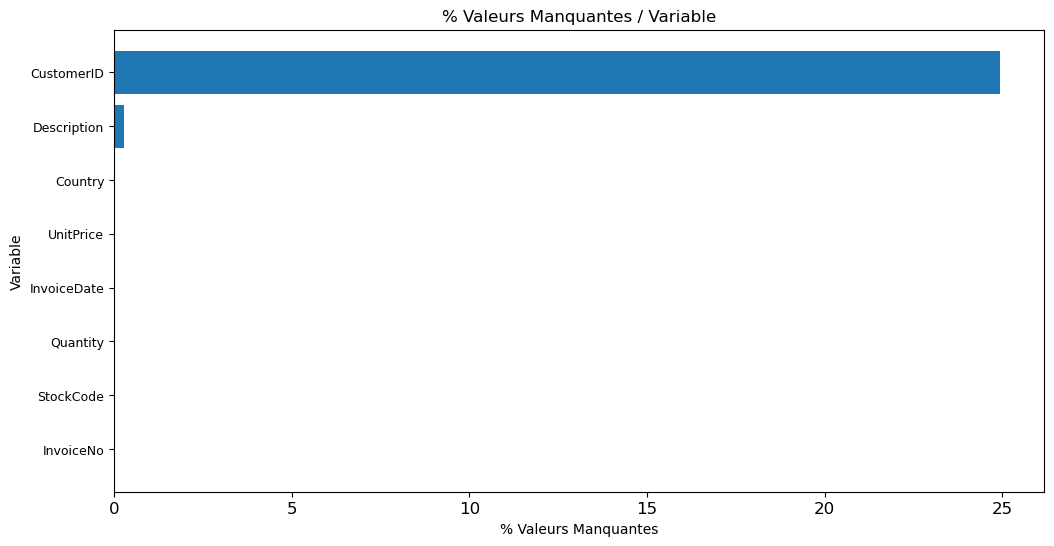

In [19]:
from matplotlib import pyplot as plt
mplt.rcParams.update(mplt.rcParamsDefault)

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["ytick.labelsize"]=9
plt.rcParams["xtick.labelsize"]=12

profilTrie=dfProfil.sort_values("%_missing_values",ascending=True) #Tri

plt.barh(profilTrie.index,profilTrie["%_missing_values"])
# Titre et libelles
plt.title('% Valeurs Manquantes / Variable')
plt.xlabel('% Valeurs Manquantes')
plt.ylabel('Variable')
plt.show()

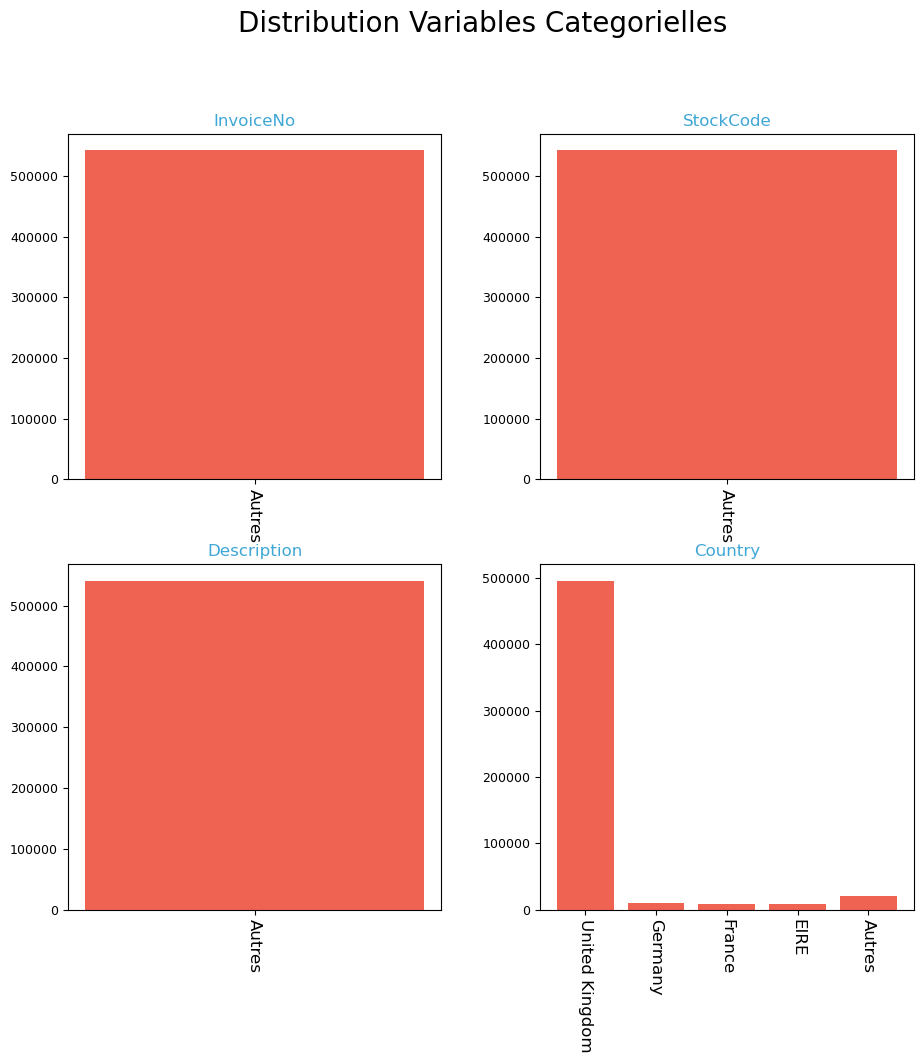

In [20]:
plotCategoricalDistributions(plt,df,2,2,10,10)

/var/folders/c7/w4lf4cp91_j_p3dxm9w00rmh0000gn/T/ipykernel_28403/3974042928.py:130: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dfQSkew=dfQuantitative.skew(skipna = True).to_frame('SKEW')


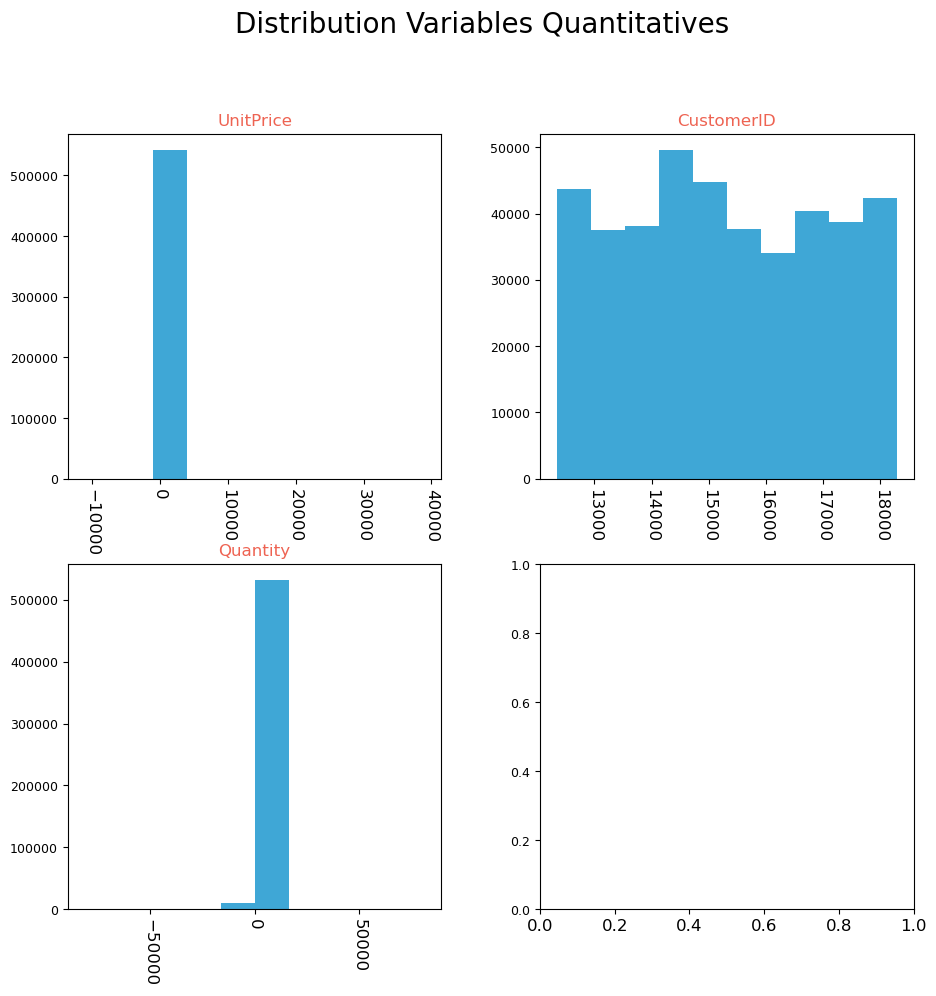

In [21]:
plotQuantitativeDistributions(plt,df,2,2,10,10)

## Boites à moustache

In [22]:
dfQuantitative=df.select_dtypes(exclude=['object','string', 'category'])

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
    
# axes est un tableau à 2 dimensions: lignes, colonnes
# pour parcourir les subplot, il faut réduire axes à une dimension avec flatten
axes=axes.flatten()
dfQuantitative['InvoiceDate']=dfQuantitative['InvoiceDate'].apply(mpl_dates.date2num)
i=0
for x in dfQuantitative.columns:
        axes[i].boxplot(dfQuantitative[x].dropna())
        axes[i].set_title(x,color='#3fa7d6')
        i+=1

/var/folders/c7/w4lf4cp91_j_p3dxm9w00rmh0000gn/T/ipykernel_28403/719045660.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfQuantitative['InvoiceDate']=dfQuantitative['InvoiceDate'].apply(mpl_dates.date2num)


## Correlations

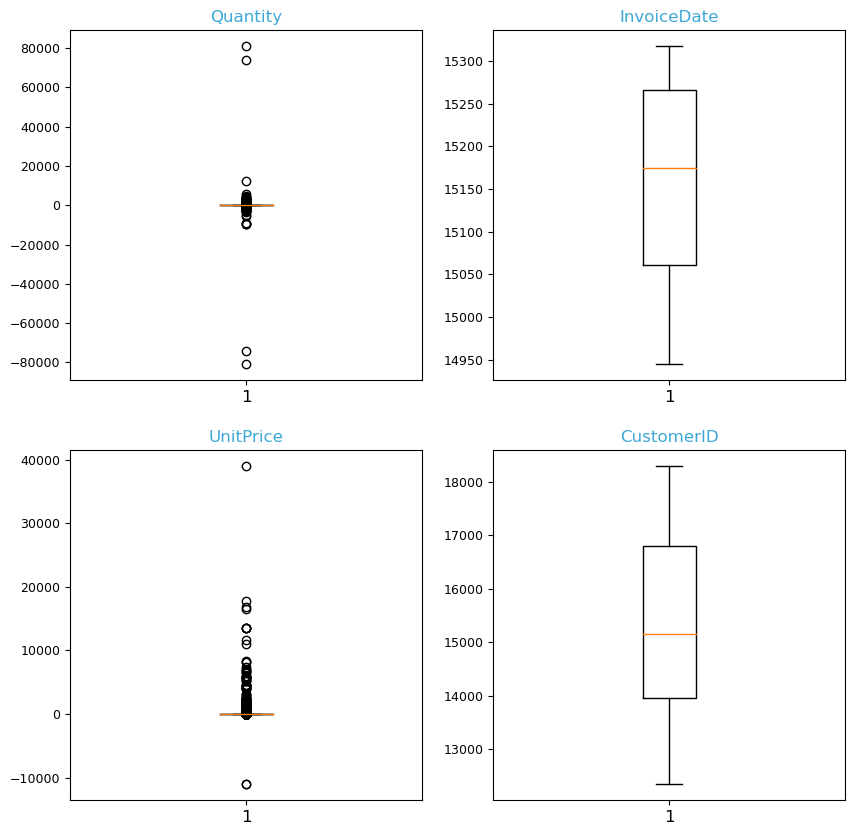

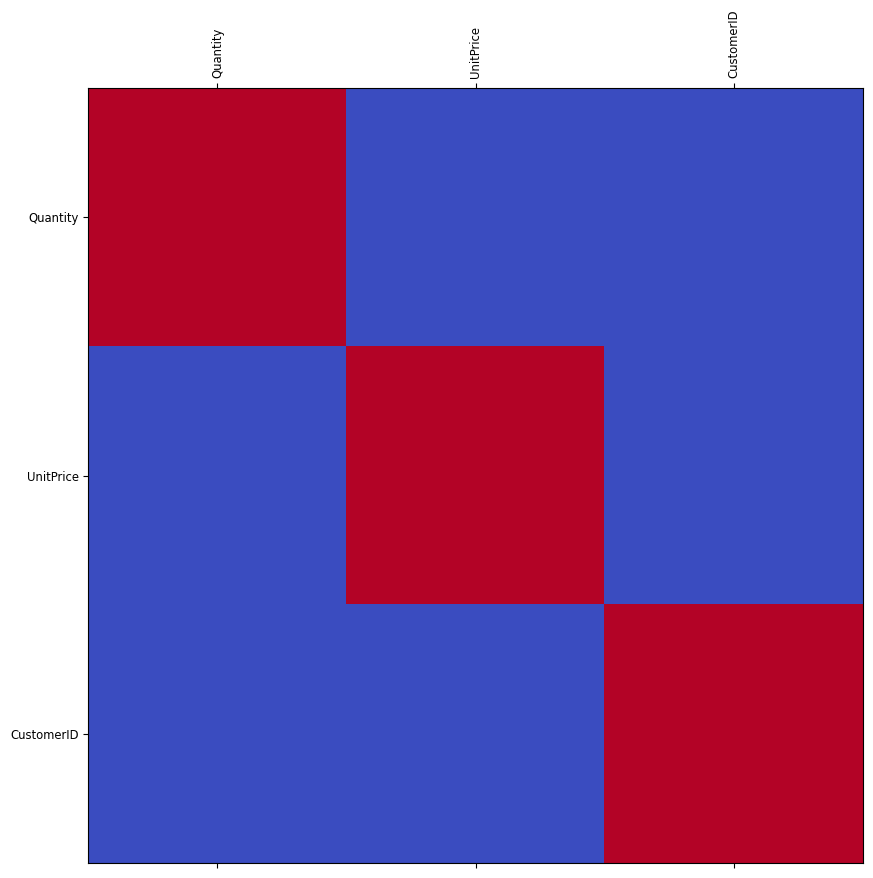

In [23]:
plotCorrelationHeatmap(plt,df)

# CREATIONS DE VARIABLES

In [24]:
# creation de la variable Prix total
df['TotalPrice']=df['Quantity']*df['UnitPrice']

In [25]:
# creation des variables Annees et mois
df["Year"]=df["InvoiceDate"].apply(lambda x: x.strftime('%Y'))
df["Month"]=df["InvoiceDate"].apply(lambda x: x.strftime('%m'))
df["InvoiceDateSimple"]=df['InvoiceDate'].dt.date # date sans de la partie hh:mm:ss
df["InvoiceDateYM"]=df['InvoiceDate'].dt.strftime('%Y-%m')

In [26]:
# creation de groupe de pays
european_countries = [
    'United Kingdom', 'France', 'Netherlands', 'Germany', 'Norway', 'EIRE', 
    'Switzerland', 'Spain', 'Poland', 'Portugal', 'Italy', 'Belgium', 'Malta',
    'Lithuania', 'Iceland', 'Channel Islands', 'Denmark', 'Cyprus', 'Sweden',
    'Finland', 'Austria', 'Greece', 'Czech Republic', 'European Community'
]

df['CountryGroup'] = 'NotEurope'
df.loc[(df.Country.isin(european_countries)), 'CountryGroup']  = 'Europe'
df.loc[(df.Country == "United Kingdom"), 'CountryGroup']  = 'UK'

In [27]:
#df['N_orders'] = df.groupby(['CustomerID', 'InvoiceDate']).InvoiceNo.transform('nunique')
#df['N_orders'] = df['N_orders'].fillna(1)

# NETTOYAGE

In [28]:
# copie par valeur
dfCleaned=df.copy(deep=True)

In [29]:
# passage en majuscule de la description, du stock code et invoice No
dfCleaned['InvoiceNo']=dfCleaned['InvoiceNo'].str.upper()
dfCleaned['StockCode']=dfCleaned['StockCode'].str.upper()
dfCleaned['Description']=dfCleaned['Description'].str.upper()

In [30]:
#suppression des doublons (en tenant compte de l'ensemble des variables)
maskDoublons=dfCleaned.duplicated()
dfCleaned=df[~maskDoublons]

In [31]:
maskConflictingUnitPrice=dfCleaned.duplicated(['InvoiceNo','StockCode','InvoiceDate','CustomerID','Quantity'],keep=False)
dfCleaned[maskConflictingUnitPrice]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,InvoiceDateSimple,InvoiceDateYM,CountryGroup
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274.0,United Kingdom,1.25,2010,12,2010-12-01,2010-12,UK
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274.0,United Kingdom,18.95,2010,12,2010-12-01,2010-12,UK
6086,536876,84879,ASSORTED COLOUR BIRD ORNAMENT,8,2010-12-03 11:36:00,3.19,NaN,United Kingdom,25.52,2010,12,2010-12-03,2010-12,UK
6186,536876,84879,ASSORTED COLOUR BIRD ORNAMENT,8,2010-12-03 11:36:00,1.69,NaN,United Kingdom,13.52,2010,12,2010-12-03,2010-12,UK
8587,537140,M,Manual,1,2010-12-05 12:53:00,0.42,12748.0,United Kingdom,0.42,2010,12,2010-12-05,2010-12,UK
8588,537140,M,Manual,1,2010-12-05 12:53:00,0.85,12748.0,United Kingdom,0.85,2010,12,2010-12-05,2010-12,UK
14436,C537581,S,SAMPLES,-1,2010-12-07 12:03:00,12.95,NaN,United Kingdom,-12.95,2010,12,2010-12-07,2010-12,UK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523705,580519,22735,RIBBON REEL SOCKS AND MITTENS,1,2011-12-04 14:51:00,7.50,NaN,United Kingdom,7.50,2011,12,2011-12-04,2011-12,UK
529859,580754,23168,CLASSIC CAFE SUGAR DISPENSER,1,2011-12-06 10:05:00,3.29,NaN,United Kingdom,3.29,2011,12,2011-12-06,2011-12,UK


Le dataframe presente des incohérences sur les prix unitaires pour les memes achats (date,produit,client) => on exclue ces lignes du dataset

In [32]:
#suppression des prix unitaires contradictoires pour un meme produit/client/date d'achat
dfCleaned=dfCleaned[~maskConflictingUnitPrice]

Les transactions sans id client ne permettent pas de distinguer les clients => nous les supprimons de l'étude

In [33]:
#suppression des achats sans CustomerID
dfCleaned=dfCleaned[dfCleaned['CustomerID'].notnull()]

In [34]:
#recherche de doublons sur le code produit/description
dfCleaned[['StockCode','Description']].drop_duplicates().sort_values([dfCleaned.columns[1],dfCleaned.columns[2]])

,StockCode,Description
31,10002,INFLATABLE POLITICAL GLOBE
103332,10080,GROOVY CACTUS INFLATABLE
5452,10120,DOGGY RUBBER
5451,10123C,HEARTS WRAPPING TAPE
12492,10124A,SPOTS ON RED BOOKCOVER TAPE
3973,10124G,ARMY CAMO BOOKCOVER TAPE
817,10125,MINI FUNKY DESIGN TAPES
...,...,...
1423,C2,CARRIAGE
317508,CRUK,CRUK Commission


In [35]:
# Exemple de produit commandé, puis remboursé
dfCleaned[(dfCleaned['TotalPrice']==-168469.6) | (dfCleaned['TotalPrice']==168469.6)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,InvoiceDateSimple,InvoiceDateYM,CountryGroup
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.6,2011,12,2011-12-09,2011-12,UK
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,-168469.6,2011,12,2011-12-09,2011-12,UK


In [36]:
# Exclusion d'opérations de remboursement (code produit qui commence par la lettre 'C')
dfCleaned=dfCleaned[~dfCleaned['InvoiceNo'].str.startswith('C')]

In [37]:
profil(dfCleaned)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std,type,missing_values,%_missing_values
InvoiceNo,392689,18529,576339,542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.0
StockCode,392689,3665,85123A,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.0
Description,392689,3877,WHITE HANGING HEART T-LIGHT HOLDER,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.0
Quantity,392689.0,NaN,NaN,NaN,13.152716,1.0,2.0,6.0,12.0,80995.0,181.596931,int64,0,0.0
InvoiceDate,392689,NaN,NaN,NaN,2011-07-10 19:19:07.882420736,2010-12-01 08:26:00,2011-04-07 11:16:00,2011-07-31 12:02:00,2011-10-20 12:53:00,2011-12-09 12:50:00,NaN,datetime64[ns],0,0.0
UnitPrice,392689.0,NaN,NaN,NaN,3.093796,0.0,1.25,1.95,3.75,8142.75,20.565579,float64,0,0.0
CustomerID,392689.0,NaN,NaN,NaN,15287.863671,12346.0,13955.0,15150.0,16791.0,18287.0,1713.519206,float64,0,0.0
Country,392689,37,United Kingdom,349198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.0
TotalPrice,392689.0,NaN,NaN,NaN,22.595468,0.0,4.95,12.39,19.8,168469.6,310.984565,float64,0,0.0
Year,392689,2,2011,367026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.0


In [38]:
dfCleaned.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,InvoiceDateSimple,InvoiceDateYM,CountryGroup
416146,572552,21494,ROTATING LEAVES T-LIGHT HOLDER,4,2011-10-24 17:07:00,2.46,14096.0,United Kingdom,9.84,2011,10,2011-10-24,2011-10,UK
219668,556106,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,2,2011-06-08 16:54:00,4.95,14056.0,United Kingdom,9.90,2011,06,2011-06-08,2011-06,UK
488845,577855,22573,STAR WOODEN CHRISTMAS DECORATION,4,2011-11-22 11:18:00,0.85,15877.0,United Kingdom,3.40,2011,11,2011-11-22,2011-11,UK
405080,571710,82581,TOILET METAL SIGN,12,2011-10-18 15:54:00,0.55,13032.0,United Kingdom,6.60,2011,10,2011-10-18,2011-10,UK
126258,547069,21982,PACK OF 12 SUKI TISSUES,12,2011-03-20 13:52:00,0.29,16710.0,United Kingdom,3.48,2011,03,2011-03-20,2011-03,UK


In [39]:
dfCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392689 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   InvoiceNo          392689 non-null  object        
 1   StockCode          392689 non-null  object        
 2   Description        392689 non-null  object        
 3   Quantity           392689 non-null  int64         
 4   InvoiceDate        392689 non-null  datetime64[ns]
 5   UnitPrice          392689 non-null  float64       
 6   CustomerID         392689 non-null  float64       
 7   Country            392689 non-null  object        
 8   TotalPrice         392689 non-null  float64       
 9   Year               392689 non-null  object        
 10  Month              392689 non-null  object        
 11  InvoiceDateSimple  392689 non-null  object        
 12  InvoiceDateYM      392689 non-null  object        
 13  CountryGroup       392689 non-null  object  

In [40]:
dfCleaned['InvoiceDate']=pd.to_datetime(dfCleaned['InvoiceDate']) #top_customers
dfCleaned.groupby('CustomerID').TotalPrice.sum().nlargest(10)
## modification

CustomerID
14646.0    280206.02
18102.0    259657.30
17450.0    194390.79
16446.0    168472.50
14911.0    143711.17
12415.0    124914.53
14156.0    117210.08
17511.0     91062.38
16029.0     80392.92
12346.0     77183.60
Name: TotalPrice, dtype: float64

In [41]:
# modification 
dfCleaned.groupby('Country').CustomerID.count().sort_values(ascending=False)

Country
United Kingdom          349198
Germany                   9024
France                    8327
EIRE                      7228
Spain                     2480
Netherlands               2363
Belgium                   2031
Switzerland               1842
Portugal                  1453
Australia                 1184
Norway                    1067
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  216
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45


# SAUVEGARDE

In [42]:
#joblib.dump(dfCleaned,"drive/MyDrive/Colab Notebooks/Datasets/dfCleaned.jbl.bz2")
joblib.dump(dfCleaned,"dfCleaned.jbl.bz2")

['dfCleaned.jbl.bz2']